In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.utils import prettify

from jaxley_mech.channels.torre90 import Phototransduction
from jaxley_mech.channels.liu04 import Leak, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Hyper


In [2]:
META = {
    "cell_type": "rod",
    "species": "salamander (Ambystoma tigrinum)",
    "reference": [
        "Torre, V., Forti, S., Menini, A., & Campani, M. (1990). Model of Phototransduction in Retinal Rods. Cold Spring Harbor Symposia on Quantitative Biology, 55(0), 563–573. https://doi.org/10.1101/SQB.1990.055.01.054",
        "Kamiyama, Y., Wu, S. M., & Usui, S. (2009). Simulation analysis of bandpass filtering properties of a rod photoreceptor network. Vision Research, 49(9), 970–978. https://doi.org/10.1016/j.visres.2009.03.003",
    ],
    "note": "The model is from Torre et al. (1990) but variable naming convention and default parameters are from Kamiyama et al. (2009).",
}

params = {
    "length" : 16, #um
    "radius": 1, #um
}

## Torre, et al. 1990

Photocurrents in respond to 10 ms flash of light in various light intensities, generated by the Torre et al. 1990 model of the rod photoreceptor. The parameters are mostly the same as reported in the paper, except `b` (proportionality constant between Ca2+ influx and photocurrent) is changed from 0.625 to 0.25, otherwise the resulted current in dark will be different from the paper.

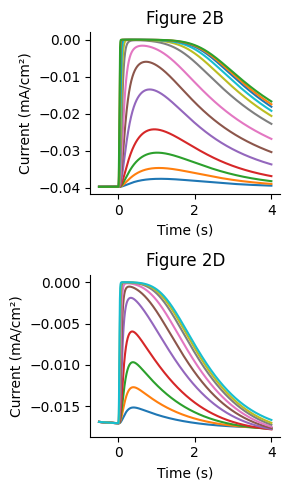

In [3]:

# Figure 2b and 2d

to_records = ["Phototransduction_Jhv", "iPhoto"]
fig, ax = plt.subplot_mosaic([["B"], ["D"]], figsize=(3, 5))

background_intensities = [0, 0.1]

for background_intensity in background_intensities:
    if background_intensity > 0:
        intensities = [2, 5, 10, 20, 50, 100,200,500, 1000, 2000]
    else:
        intensities = [0.2, 0.5, 1, 2, 5, 10, 20, 50, 100,200,500, 1000, 2000]

    for intensity in intensities:
        pre_light_time = 8000  # ms
        light_on_time = 20  # ms
        total_time = pre_light_time + 4000 # ms
        dt = 0.5 # ms
        time_steps = int(total_time // dt + 1)

        cell = Compartment()
        cell.insert(Phototransduction(solver='newton'))
        cell.insert(Leak())

        for name, param in params.items():
            cell.set(name, param)

        cell.init_states()

        Jhv = jnp.zeros(time_steps) + background_intensity
        light_on_start = int(pre_light_time / dt)
        light_on_end = int((pre_light_time + light_on_time) / dt)

        Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

        # Apply the light stimuli by "clamping" Jhv
        cell.clamp("Phototransduction_Jhv", Jhv, verbose=False)

        for rec in to_records:
            cell.record(rec, verbose=False)

        # Run the simulation
        s = jx.integrate(cell, delta_t=dt, t_max=total_time)
        s = prettify(s, to_records, dt) 
        
        num = "B" if background_intensity == 0 else "D"
        ax[num].plot((s["time"]-pre_light_time)[light_on_start-int(500/dt):]/1000, s["iPhoto"][light_on_start-int(500/dt):], label=f"{intensity} R*/s")

        ax[num].spines[['top', 'right']].set_visible(False)
        ax[num].set_xlabel("Time (s)")
        ax[num].set_ylabel("Current (mA/cm²)")
        ax[num].set_title(f"Figure 2{num}")

fig.tight_layout()

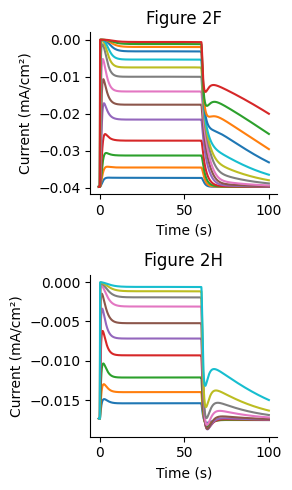

In [4]:
# Figure 2b and 2d

to_records = ["Phototransduction_Jhv", "iPhoto"]
fig, ax = plt.subplot_mosaic([["F"], ["H"]], figsize=(3, 5))

background_intensities = [0, 0.1]

for background_intensity in background_intensities:
    if background_intensity > 0:
        intensities = [0.05, 0.1,0.2, 0.5, 1, 2, 5, 10, 20, 50]
    else:
        intensities = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]

    for intensity in intensities:
        pre_light_time = 10000  # ms
        light_on_time = 60000  # ms
        total_time = pre_light_time + 100000 # ms
        dt = 0.5 # ms
        time_steps = int(total_time // dt + 1)

        cell = Compartment()
        cell.insert(Phototransduction(solver='newton'))
        cell.insert(Leak())

        for name, param in params.items():
            cell.set(name, param)

        cell.init_states()

        Jhv = jnp.zeros(time_steps) + background_intensity
        light_on_start = int(pre_light_time / dt)
        light_on_end = int((pre_light_time + light_on_time) / dt)

        Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

        # Apply the light stimuli by "clamping" Jhv
        cell.clamp("Phototransduction_Jhv", Jhv, verbose=False)

        for rec in to_records:
            cell.record(rec, verbose=False)

        # Run the simulation
        s = jx.integrate(cell, delta_t=dt, t_max=total_time)
        s = prettify(s, to_records, dt) 
        
        num = "F" if background_intensity == 0 else "H"
        ax[num].plot((s["time"]-pre_light_time)[light_on_start-int(500/dt):]/1000, s["iPhoto"][light_on_start-int(500/dt):], label=f"{intensity} R*/s")

        ax[num].spines[['top', 'right']].set_visible(False)
        ax[num].set_xlabel("Time (s)")
        ax[num].set_ylabel("Current (mA/cm²)")
        ax[num].set_title(f"Figure 2{num}")

fig.tight_layout()

In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-02-21 09:38:49CET

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.32.0

jaxley_mech: 0.3.0
matplotlib : 3.10.0
jaxley     : 0.6.2
jax        : 0.4.31

Watermark: 2.5.0

